## Buoyancy Frequency and Drag Figures

For this script to run you need to download 'revised_stat'. This script is written by Madie Mamer (mmamer3@gatech.edu).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors
import cmocean as cmo
import cmasher as cmr
import seaborn as sns
from matplotlib.colors import ListedColormap

In [10]:
nu = 1.95 * 10 **(-6)
sec_to_year = 3*10**7
path = 'revised_stat'
F1cu2_body = pd.read_csv(path + '/f1cu2_avg_body.csv')

F2cu2_body = pd.read_csv(path + '/f2cu2_avg_body.csv')
F2cu2_bf_body = pd.read_csv(path + '/f2cu2_bf_avg_body.csv')

F3cu2_body = pd.read_csv(path + '/f3cu2_avg_body.csv')

F4cu2_body = pd.read_csv(path + '/f4cu2_avg_body.csv')
F4cu2_bf_body = pd.read_csv(path + '/f4cu2_bf_avg_body.csv')

F5cu2_body = pd.read_csv(path + '/f5cu2_avg_body.csv')
F5cu2_bf_body = pd.read_csv(path + '/f5cu2_bf_avg_body.csv')

## drag Function

For this function you need to pass a time-averaged domain body file (df) and set True or False for if the domain is slanted. You also need to give it the freshwater discharge velocity in m/s (u_f).
This function calculates the near wall velocity gradientand returns it as an array.

In [11]:
def drag(df, slanted, u_f):    
    big_m_vel = pd.DataFrame(index = range(200,3200), columns =['x','m_vel', 'cd','freeVel'] )
    nu = 1.95 * 10 **(-6)
    for i in range(200,3200):
        x1 = i/100
        x2 = x1 + 0.01
         
        df2 = df.iloc[np.where(df['x'] >= x1)]
        df3 = df2.iloc[np.where(df2['x'] <=x2)]
        freeVel = np.max(abs(df3['avg_xVel']))
        if slanted == True:
            df4 = df3.iloc[np.where(df3['y'] >= (0.045 - 0.00872686 * (x1 - 1.1)))] #if you have an angled pipe
        else:
            df4 = df3.iloc[np.where(df3['y'] >= 0.045)]
        vel = df4['avg_xVel'][::-1]
        dense_201 = df4.iloc[:,3]
        t = np.linspace(0.045,0.05,len(vel))
        A = np.vstack([t, np.ones(len(vel))]).T
        m_vel, c = np.linalg.lstsq(A, abs(vel), rcond=None)[0];
        big_m_vel.iloc[i-200,1] = m_vel
        big_m_vel.iloc[i-200,0] = float(i/100) - 2
        big_m_vel.iloc[i-200,2] = (nu*m_vel) / u_f**2
        big_m_vel.iloc[i-200,3] = freeVel
    return big_m_vel

##Need velocity gradients for this one
velGrad_F1cu2 = drag(F1cu2_body.dropna(), False, 0.05)

velGrad_F2cu2 = drag(F2cu2_body.dropna(), False, 0.005)
velGrad_bf_F2cu2 = drag(F2cu2_bf_body.dropna(), False, 0.005)

velGrad_F3cu2 = drag(F3cu2_body.dropna(), False, 0.0005)

velGrad_F4cu2 = drag(F4cu2_body.dropna(), True, 0.005)
velGrad_bf_F4cu2 = drag(F4cu2_bf_body.dropna(), True, 0.005)

velGrad_F5cu2 = drag(F5cu2_body.dropna(), True, 0.005)
velGrad_bf_F5cu2 = drag(F5cu2_bf_body.dropna(), True, 0.005)


## Below we smooth the velocity gradients and drag with a given kernel size

In [4]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

cd_f1 = np.convolve(velGrad_F1cu2['cd'],kernel,mode = 'same')
cd_f2 = np.convolve(velGrad_F2cu2['cd'],kernel,mode = 'same')
cd_f3 = np.convolve(velGrad_F3cu2['cd'], kernel, mode = 'same')
cd_f4 = np.convolve(velGrad_F4cu2['cd'],kernel,mode = 'same')
cd_f5 = np.convolve(velGrad_F5cu2['cd'],kernel,mode = 'same')

cd_bf_f2 = np.convolve(velGrad_bf_F2cu2['cd'],kernel,mode = 'same')
cd_bf_f4 = np.convolve(velGrad_bf_F4cu2['cd'],kernel,mode = 'same')
cd_bf_f5 = np.convolve(velGrad_bf_F5cu2['cd'],kernel,mode = 'same')


## nSquared function

For this function to run you need to pass a time-averaged body domain file (df) and a True of False statement for if the domain is slanted. This script finds the density gradient throughout the water column and uses that the calculate the buoyancy frequencym returned as an array. 

In [12]:
def nSquared(df, slanted):
    j = 0
    nsquare = pd.DataFrame(0,index = range(200,3200), columns = ['x','nSq'])
    for i in range(200,3200):   
        df2 = df.iloc[np.where(df['x'] >= i/100)]
        df3 = df2.iloc[np.where(df2['x']<=i/100 + 0.01)]
        if slanted == True:
            df4 = df3.iloc[np.where(df3['y'] >= 0.025 - 0.00872686 * (i/100 - 1.1))] #for case 4
        else:
            df4 = df3.iloc[np.where(df3['y'] >= 0)]
        dense = df4['avgDense']
        t = np.linspace(0.0,0.05,len(dense))
        A = np.vstack([t, np.ones(len(dense))]).T
        m_dense, c = np.linalg.lstsq(A, dense, rcond=None)[0]
        nsquare.iloc[j,0] = i/100 - 2
        nsquare.iloc[j,1] = ((-9.81/(1000)) * m_dense).astype('float')
        j = j+1
        
    return nsquare

nsquare_F1cu2 = nSquared(F1cu2_body, False)

nsquare_F2cu2 = nSquared(F2cu2_body, False)
nsquare_bf_F2cu2 = nSquared(F2cu2_bf_body, False)

nsquare_F3cu2 = nSquared(F3cu2_body, False)

nsquare_F4cu2 = nSquared(F4cu2_body, True)
nsquare_bf_F4cu2 = nSquared(F4cu2_bf_body, True)

nsquare_F5cu2 = nSquared(F5cu2_body, False)
nsquare_bf_F5cu2 = nSquared(F5cu2_bf_body, False)

In [13]:
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size

nSq_f1 = np.convolve(nsquare_F1cu2['nSq'],kernel,mode = 'same')
nSq_f2 = np.convolve(nsquare_F2cu2['nSq'],kernel,mode = 'same')
nSq_f3 = np.convolve(nsquare_F3cu2['nSq'],kernel,mode = 'same')
nSq_f4 = np.convolve(nsquare_F4cu2['nSq'],kernel,mode = 'same')
nSq_f5 = np.convolve(nsquare_F5cu2['nSq'],kernel,mode = 'same')

nSq_bf_f2 = np.convolve(nsquare_bf_F2cu2['nSq'],kernel,mode = 'same')
nSq_bf_f4 = np.convolve(nsquare_bf_F4cu2['nSq'],kernel,mode = 'same')
nSq_bf_f5 = np.convolve(nsquare_bf_F5cu2['nSq'],kernel,mode = 'same')


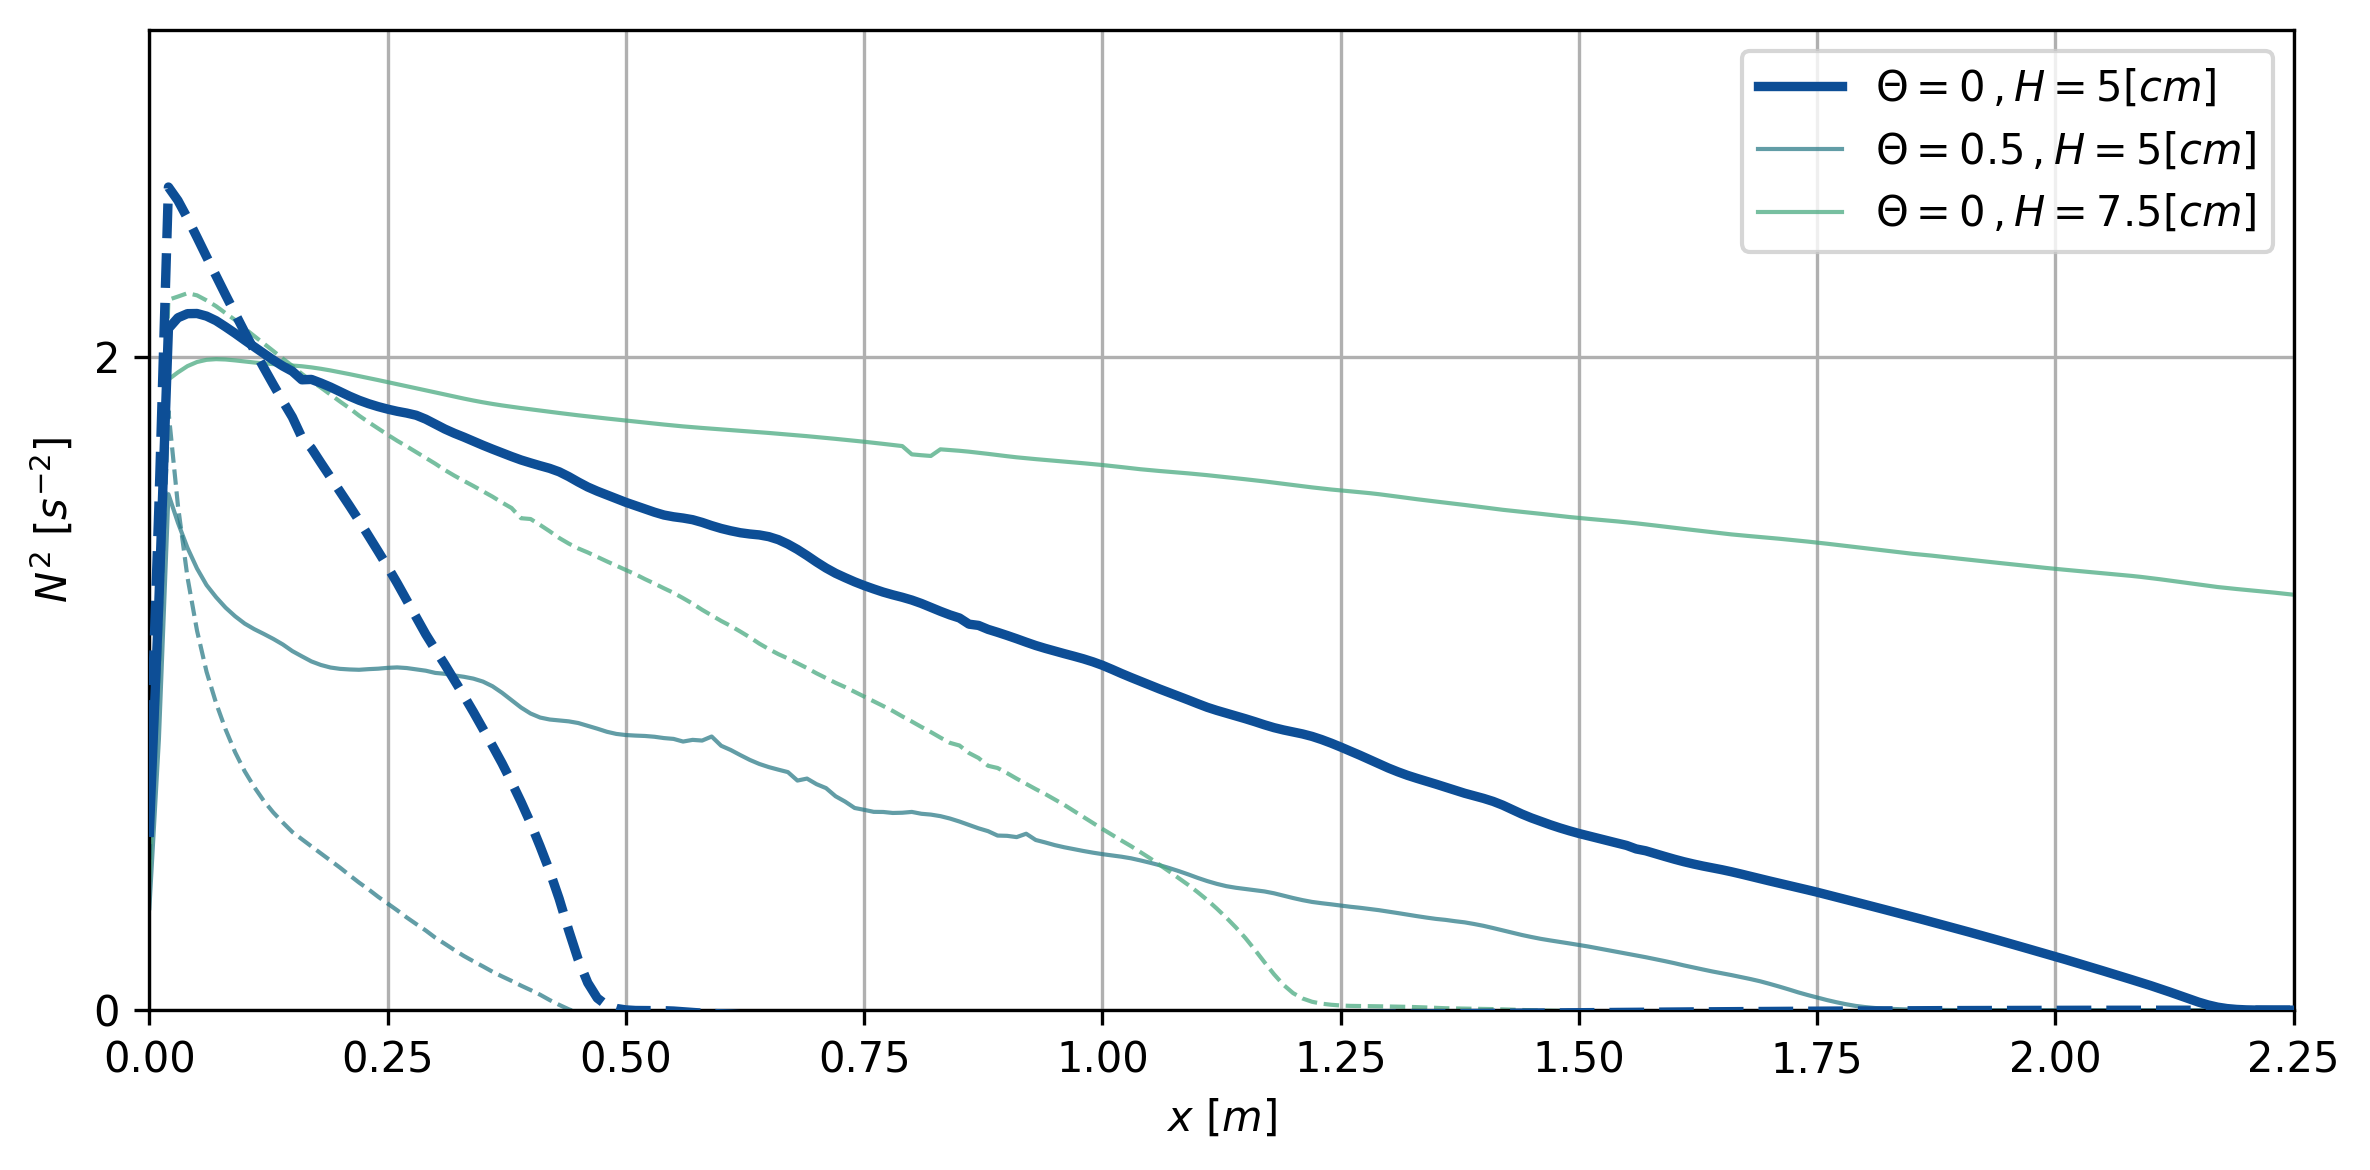

In [19]:
fig, ax = plt.subplots(1, figsize = (8,4),dpi = 300);

colors = cmo.cm.haline(np.linspace(0,1,6))
#fast, = ax.plot(nsquare_F1cu2['x'], nSq_f1, color = colors[3], linewidth = 1, zorder = 2, alpha = 0.75);
medium, = ax.plot(nsquare_F2cu2['x'], nSq_f2, color = colors[1], linewidth = 2.25, zorder = 3);
#slow, = ax.plot(nsquare_F3cu2['x'], nSq_f3, color = colors[4], linewidth = 1, zorder = 2, alpha = 0.75);
slant, =  ax.plot(nsquare_F4cu2['x'], nSq_f4, color = colors[2], linewidth = 1, zorder = 2, alpha = 0.75);
thick, =  ax.plot(nsquare_F5cu2['x'], nSq_f5, color = colors[3], linewidth = 1, zorder = 2, alpha = 0.75);

ax.plot(nsquare_bf_F2cu2['x'], nSq_bf_f2, color = colors[1],linestyle = '--', linewidth = 2.25, zorder = 3);
ax.plot(nsquare_bf_F4cu2['x'], nSq_bf_f4, color = colors[2], linestyle = '--', linewidth = 1, zorder = 2, alpha = 0.75);
ax.plot(nsquare_bf_F5cu2['x'], nSq_bf_f5, color = colors[3], linestyle = '--', linewidth = 1, zorder = 2, alpha = 0.75);

ax.set_yticks([0,2,4,6]); ax.set_yticklabels(['0','2','4','6'])
ax.legend([medium, slant, thick],['$\Theta = 0 \, , H = 5 [cm]$', '$\Theta = 0.5 \, , H = 5 [cm]$',\
                                             '$\Theta = 0 \, , H = 7.5 [cm]$',]) 
ax.set_xlim(0,2.25); ax.set_ylim(0,3.0);
ax.grid(zorder = 1); 

ax.set_xlabel('$x \,\, [m]$'); ax.set_ylabel('$N^2 \,\, [s^{-2}]$');
plt.tight_layout()
plt.savefig('buoyancy.png',dpi = 500)

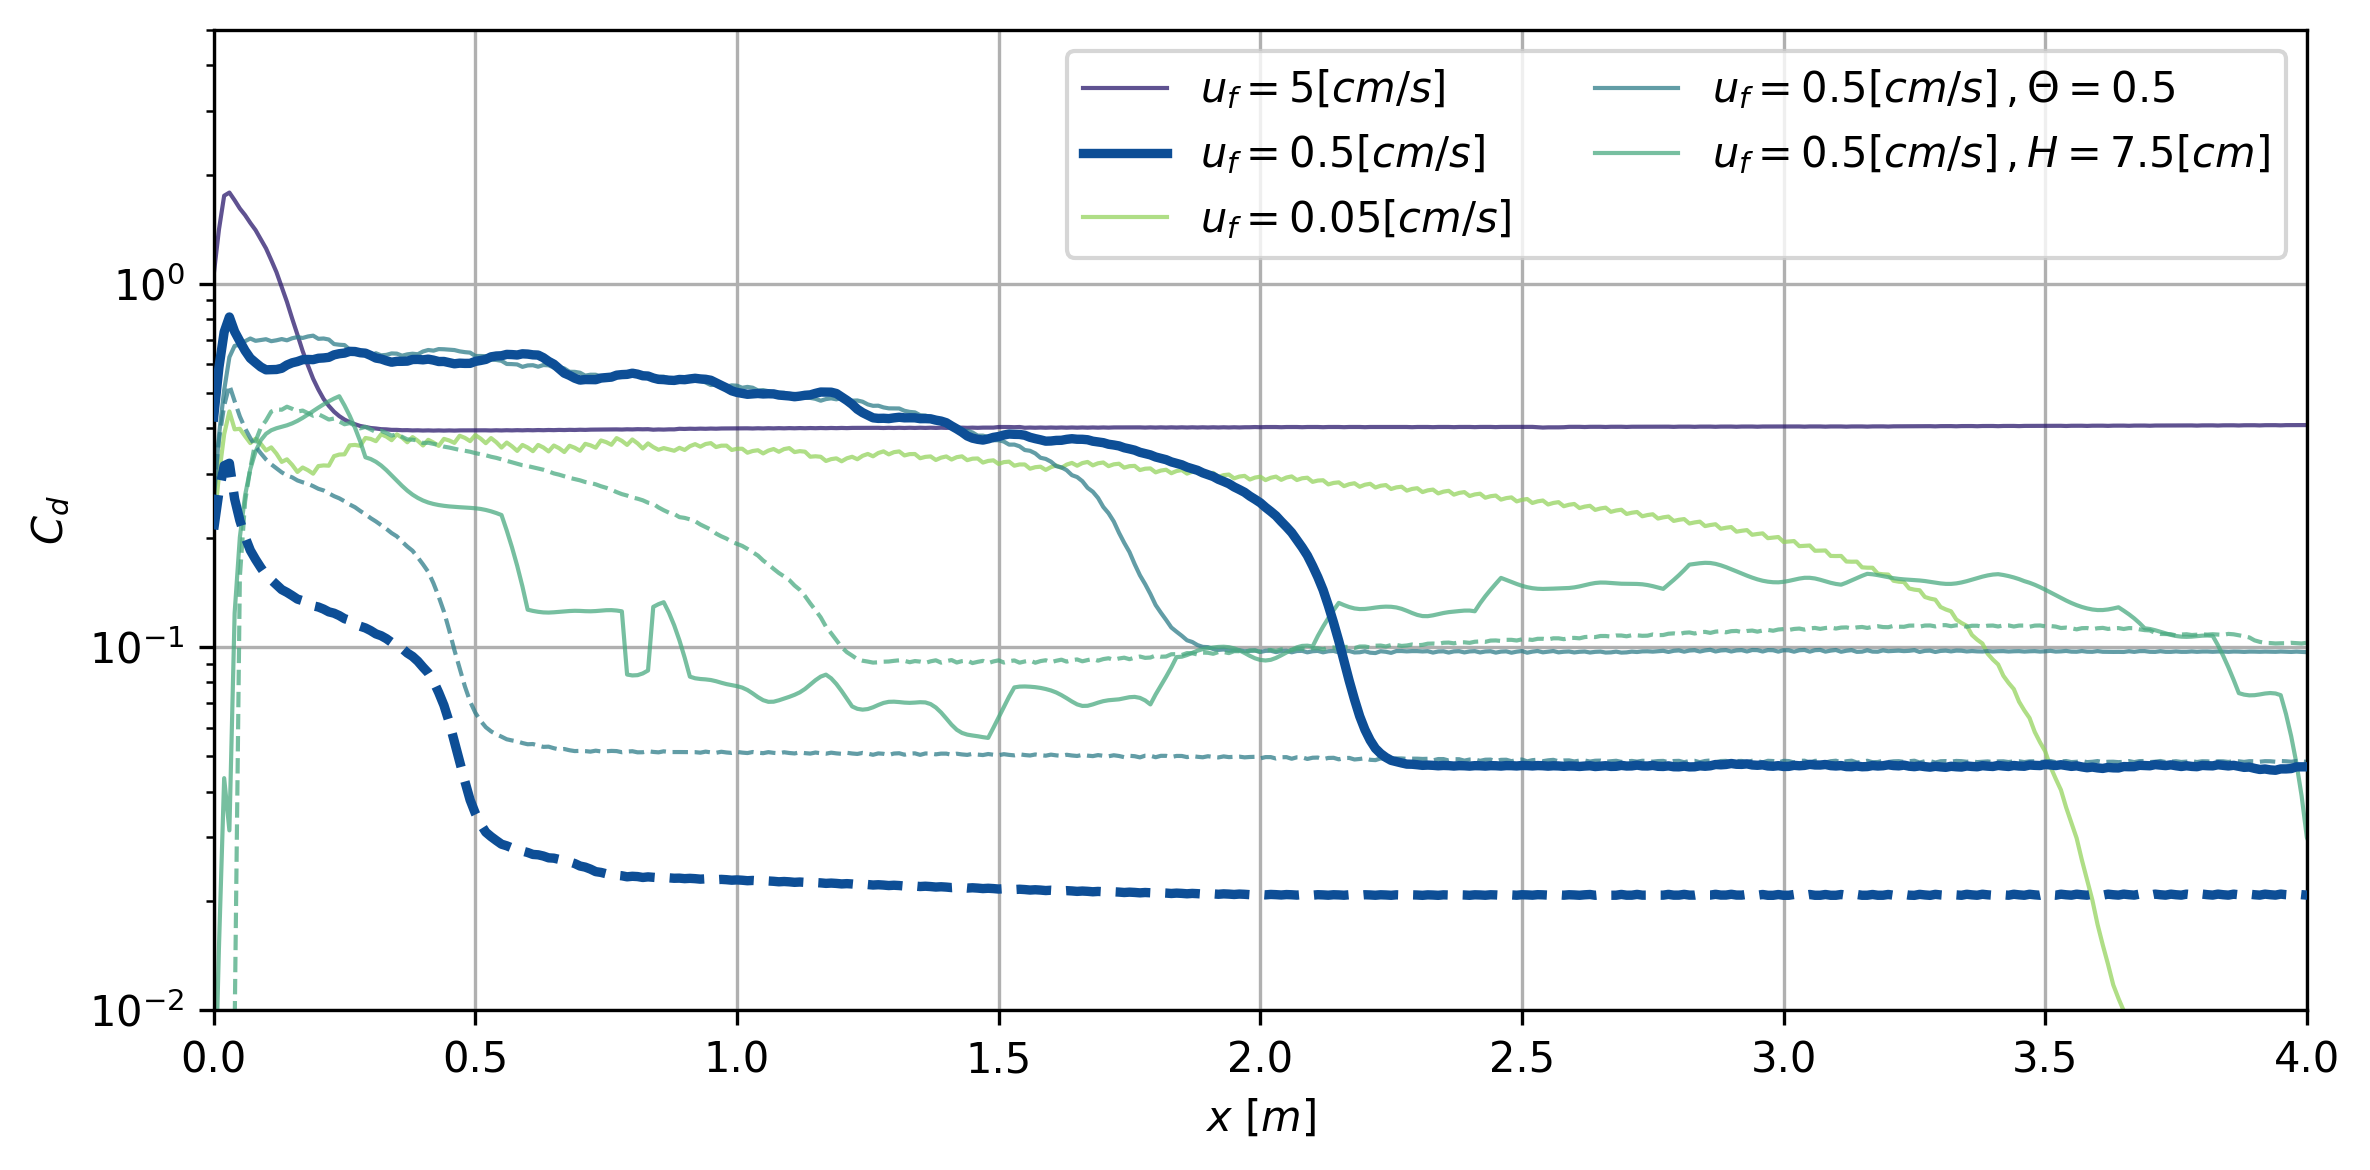

In [18]:
fig, ax = plt.subplots(1, figsize = (8,4),dpi = 300);

colors = cmo.cm.haline(np.linspace(0,1,6))
fast, = ax.plot(velGrad_F1cu2['x'], cd_f1, color = colors[0], linewidth = 1, zorder = 2, alpha = 0.75);
medium, = ax.plot(velGrad_F2cu2['x'], cd_f2, color = colors[1], linewidth = 2.25, zorder = 3);
slow, = ax.plot(velGrad_F3cu2['x'], cd_f3, color = colors[4], linewidth = 1, zorder = 2, alpha = 0.75);
slant, =  ax.plot(velGrad_F4cu2['x'], cd_f4, color = colors[2], linewidth = 1, zorder = 2, alpha = 0.75);
thick, =  ax.plot(velGrad_F5cu2['x'], cd_f5, color = colors[3], linewidth = 1, zorder = 2, alpha = 0.75);

ax.plot(velGrad_bf_F2cu2['x'], cd_bf_f2, color = colors[1],linestyle = '--', linewidth = 2.25, zorder = 3);
ax.plot(velGrad_bf_F4cu2['x'], cd_bf_f4, color = colors[2], linestyle = '--', linewidth = 1, zorder = 2, alpha = 0.75);
ax.plot(velGrad_bf_F5cu2['x'], cd_bf_f5, color = colors[3], linestyle = '--', linewidth = 1, zorder = 2, alpha = 0.75);

#ax.set_yticks([0,2,4,6]); ax.set_yticklabels(['0','2','4','6'])
ax.legend([fast, medium, slow, slant, thick],
          ['$u_f = 5 [cm/s]$','$u_f = 0.5 [cm/s]$', '$u_f = 0.05 [cm/s]$',
           '$u_f = 0.5 [cm/s] \, , \Theta = 0.5$', '$u_f = 0.5 [cm/s]\, , H = 7.5 [cm]$',], ncols = 2) 
ax.set_xlim(0,4); ax.set_ylim(0.01,5.0);
ax.set_yscale('log');
ax.grid(zorder = 1); 
ax.set_xlabel('$x \,\, [m]$'); ax.set_ylabel('$C_d$');
plt.tight_layout()
plt.savefig('drag.png',dpi = 500)